In [ ]:
# in case umap is not present
!pip install umap-learn

     |████████████████████████████████| 81kB 3.8MB/s 
     |████████████████████████████████| 1.2MB 8.7MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.1-cp37-none-any.whl size=76569 sha256=3ae723215220a40c0ef2bfa25a3fdfeb3204bf9f38476f6e80365225ad7ffac9
  Stored in directory: /root/.cache/pip/wheels/ad/df/d5/a3691296ff779f25cd1cf415a3af954b987fb53111e3392cf4
  Created wheel for pynndescent: filename=pynndescent-0.5.2-cp37-none-any.whl size=51351 sha256=b1e6c462f8f1ac1b4a5148c950cbc5fecc7ffd98e1267f1dfc7c9b8beb4c1523
  Stored in directory: /root/.cache/pip/wheels/ba/52/4e/4c28d04d144a28f89e2575fb63628df6e6d49b56c5ddd0c74e
Successfully built umap-learn pynndescent


In [ ]:
import pandas, seaborn, umap, numpy, collections

import sklearn, sklearn.preprocessing, sklearn.decomposition, sklearn.manifold
import scipy, scipy.stats
import statsmodels, statsmodels.stats, statsmodels.stats.multitest

import matplotlib, matplotlib.pyplot
matplotlib.rcParams.update({'font.size':20, 'font.family':'sans-serif', 'xtick.labelsize':20, 'ytick.labelsize':20, 'figure.figsize':(9, 6), 'axes.labelsize':20})

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# User-defined variables

In [ ]:
storage_file = '/content/drive/MyDrive/hi/research/huvec/results/untargeted/cell_number_sample_and_batch_normalized_log10_intensities_untargeted_data.csv'
annotation_file = '/content/drive/MyDrive/hi/research/huvec/results/untargeted/Annotations of Adrians hits.xlsx'

In [ ]:
treatments = ['EGM', '1.0', '10.0', '100.0']
timepoints = [0, 4, 24]

conditions = [('EGM', 0), ('EGM', 4), ('EGM', 24)]
for timepoint in timepoints[1:]:
  for treatment in treatments[1:]:
    condition = (treatment, timepoint)
    conditions.append(condition)
print(conditions, len(conditions))

condition_colors = ['white', 'white', 'white', 'green', 'yellow', 'red', 'green', 'yellow', 'red']
condition_labels = ['c 0h', 'c 4h', 'c 24h', '0.5 4h', '5 4h', '50 4h', '0.5 24h', '5 24h', '50 24h']

print(condition_colors, len(condition_colors))

[('EGM', 0), ('EGM', 4), ('EGM', 24), ('1.0', 4), ('10.0', 4), ('100.0', 4), ('1.0', 24), ('10.0', 24), ('100.0', 24)] 9
['white', 'white', 'white', 'green', 'yellow', 'red', 'green', 'yellow', 'red'] 9


# Read information

## read metadata

In [ ]:
# read ottars annotation file
annotation = pandas.read_excel(annotation_file, usecols=['ottar calls', 'dose-responding mz', 'annotated mz'])
annotation.head()

,ottar calls,dose-responding mz,annotated mz
0,glutamate,146.0799,146.043687
1,N-acetyl-glutamate,102.0536,102.053623
2,N-acetyl-glutamate,144.0646,144.064567
3,pantothenic acid,218.1016,218.101624
4,cholesterol derivative,321.1625,321.209535


In [ ]:
annotation['diff'] = numpy.abs(annotation['dose-responding mz'] - annotation['annotated mz'])
print(annotation.shape)
annotation = annotation[annotation['diff'] < 0.01]
print(annotation.shape)
#annotation.tail(50)

(118, 4)
(64, 4)


## read data

In [ ]:
wdf = pandas.read_csv(storage_file, index_col=0)
print(wdf.shape)
wdf.head()

(123, 1233)


,Treatment,Time,Replicate,X59.01097,X61.017890000000001,X67.016220000000004,X74.021450000000002,X77.052040000000005,X77.052049999999994,X78.956580000000002,X78.956770000000006,X79.955420000000004,X80.962869999999995,X80.962720000000004,X82.951819999999998,X84.006739999999994,X84.043059999999997,X84.949100000000001,X85.027289999999994,X85.027019999999993,X85.027270000000001,X86.991519999999994,X87.006460000000004,X88.037970000000001,X88.037940000000006,X88.038039999999995,X88.03792,X89.022130000000004,X89.022099999999995,X89.040549999999996,X92.032160000000005,X92.031949999999995,X92.925600000000003,X93.043189999999996,X94.922759999999997,X96.919939999999997,X96.965789999999998,X96.967179999999999,X96.957989999999995,X96.965829999999997,...,X885.56862999999998,X885.57101,X886.53539000000001,X886.55880999999999,X886.57330999999999,X893.19449999999995,X893.21762000000001,X894.19538999999997,X894.21055000000001,X894.86288000000002,X906.21198000000004,X906.23701000000005,X918.79764999999998,X918.81568000000004,X918.83290999999997,X928.81326000000001,X928.82665999999995,X928.85361999999998,X928.86716999999999,X932.19215999999994,X932.20804999999996,X957.19478000000004,X957.21433999999999,X957.22663,X962.81850999999995,X962.83609000000001,X962.85298,X962.86944000000005,X968.30682999999999,X970.29764,X970.31845999999996,X970.33735000000001,X972.28162999999995,X986.81443999999999,X996.20851000000005,X996.78913999999997,X996.80704000000003,X996.82538,X996.84303,X996.86003000000005
0,EGM,0.0,0.0,2.731190,3.039996,2.498900,3.146793,2.926058,3.101473,4.249783,3.659928,2.675828,2.698426,2.835321,3.263095,3.015066,2.938611,2.771732,2.994916,2.569723,2.977499,3.331975,2.662741,3.665733,3.645038,2.769425,2.743793,4.397969,3.612091,3.062474,3.608017,3.098851,3.949611,2.609377,3.924130,3.195544,4.520370,4.703177,2.949756,4.252155,...,3.684713,3.504004,3.118662,3.310416,3.110021,3.646444,3.556255,2.969109,2.971801,3.184817,2.769092,2.892342,3.024038,3.064213,3.085544,3.635307,3.859158,3.857018,3.728960,3.087690,3.087883,3.428445,3.493868,3.400716,3.214216,3.334671,3.384709,3.415102,2.978815,3.022200,3.021206,2.995128,3.012682,3.068779,3.026200,3.681500,3.728084,3.902864,3.798414,3.779298
1,EGM,0.0,1.0,2.577060,2.966918,2.478636,3.080018,2.975931,3.142122,4.154512,3.619230,2.579870,2.562354,2.487779,3.258477,2.886799,2.854834,2.756858,3.007140,2.691261,3.068997,3.254947,2.539483,3.745788,3.727281,2.766418,2.712809,4.476157,3.668902,3.185888,3.538519,3.105857,3.923285,2.471512,4.182124,3.390994,4.219277,4.737366,2.993527,4.222383,...,3.625102,3.257475,2.969984,2.943847,2.821723,3.572133,3.534212,2.957405,2.959623,3.138686,2.805983,2.881742,3.038560,3.072207,3.068547,3.562690,3.816319,3.637790,3.717931,3.045000,3.049544,3.361241,3.383137,3.186481,3.128215,3.269217,3.395243,3.347042,3.103678,3.182975,3.197100,3.191962,3.090010,3.086108,2.856756,3.666367,3.817882,3.767177,3.784470,3.692333
2,EGM,0.0,2.0,2.567796,3.102377,2.315301,3.174088,3.080577,3.078214,3.950247,3.553190,2.447427,2.567267,2.467664,3.299520,2.868828,2.944417,2.891972,2.964754,2.616670,2.956515,3.345296,2.543528,3.662276,3.662167,2.855282,2.924238,4.572164,3.640099,3.137590,3.662951,3.321059,4.618832,2.497167,4.263248,3.499691,4.645017,4.724440,2.949756,4.259571,...,3.372456,3.223758,3.059874,3.043612,2.866050,3.409097,3.457334,2.832361,2.832637,3.139151,2.979729,3.026377,3.250336,3.299959,3.271043,3.775912,3.706156,3.971052,3.853376,2.860173,2.848091,3.188977,3.151786,3.090118,3.307722,3.408314,3.476060,3.459793,3.107535,3.193450,3.201853,3.251763,3.087607,3.325044,2.495992,3.780564,3.908326,3.861871,3.913619,3.892816
3,EGM,0.0,3.0,2.700993,3.041685,2.328574,3.091159,2.993070,3.046918,4.165901,3.546743,2.492790,2.705565,2.633503,3.303501,2.936790,3.100368,2.895259,3.112989,2.514703,2.908327,3.495694,2.696874,3.828928,3.827009,2.881977,2.872404,4.615308,3.755558,3.043079,3.613132,3.223012,4.592933,2.670872,3.749708,3.376602,4.460777,4.687126,2.928184,4.299938,...,3.057176,3.492650,3.

In [ ]:
wdf.columns[wdf.isna().any()].tolist()

[]

In [ ]:
peak_names = wdf.columns.to_list()[3:]
print(peak_names)
print(len(peak_names))

['X59.01097', 'X61.017890000000001', 'X67.016220000000004', 'X74.021450000000002', 'X77.052040000000005', 'X77.052049999999994', 'X78.956580000000002', 'X78.956770000000006', 'X79.955420000000004', 'X80.962869999999995', 'X80.962720000000004', 'X82.951819999999998', 'X84.006739999999994', 'X84.043059999999997', 'X84.949100000000001', 'X85.027289999999994', 'X85.027019999999993', 'X85.027270000000001', 'X86.991519999999994', 'X87.006460000000004', 'X88.037970000000001', 'X88.037940000000006', 'X88.038039999999995', 'X88.03792', 'X89.022130000000004', 'X89.022099999999995', 'X89.040549999999996', 'X92.032160000000005', 'X92.031949999999995', 'X92.925600000000003', 'X93.043189999999996', 'X94.922759999999997', 'X96.919939999999997', 'X96.965789999999998', 'X96.967179999999999', 'X96.957989999999995', 'X96.965829999999997', 'X97.009529999999998', 'X100.0742', 'X102.02508', 'X102.05382', 'X102.05362', 'X102.94647999999999', 'X102.94672', 'X102.95457', 'X104.03297000000001', 'X104.95166', 'X

# Spot check for adrenaline metabolite sulfate


In [ ]:
wdf.tail()

,Treatment,Time,Replicate,X59.01097,X61.017890000000001,X67.016220000000004,X74.021450000000002,X77.052040000000005,X77.052049999999994,X78.956580000000002,X78.956770000000006,X79.955420000000004,X80.962869999999995,X80.962720000000004,X82.951819999999998,X84.006739999999994,X84.043059999999997,X84.949100000000001,X85.027289999999994,X85.027019999999993,X85.027270000000001,X86.991519999999994,X87.006460000000004,X88.037970000000001,X88.037940000000006,X88.038039999999995,X88.03792,X89.022130000000004,X89.022099999999995,X89.040549999999996,X92.032160000000005,X92.031949999999995,X92.925600000000003,X93.043189999999996,X94.922759999999997,X96.919939999999997,X96.965789999999998,X96.967179999999999,X96.957989999999995,X96.965829999999997,...,X885.56862999999998,X885.57101,X886.53539000000001,X886.55880999999999,X886.57330999999999,X893.19449999999995,X893.21762000000001,X894.19538999999997,X894.21055000000001,X894.86288000000002,X906.21198000000004,X906.23701000000005,X918.79764999999998,X918.81568000000004,X918.83290999999997,X928.81326000000001,X928.82665999999995,X928.85361999999998,X928.86716999999999,X932.19215999999994,X932.20804999999996,X957.19478000000004,X957.21433999999999,X957.22663,X962.81850999999995,X962.83609000000001,X962.85298,X962.86944000000005,X968.30682999999999,X970.29764,X970.31845999999996,X970.33735000000001,X972.28162999999995,X986.81443999999999,X996.20851000000005,X996.78913999999997,X996.80704000000003,X996.82538,X996.84303,X996.86003000000005
118,100.0,24.0,7.0,2.779846,3.172528,2.963769,3.251544,2.761526,3.189147,3.857269,3.547562,2.794847,3.092258,2.737097,3.605848,3.018233,3.491667,3.275045,3.133100,3.056535,3.174188,3.533657,2.594479,3.689094,3.714310,2.971458,2.825774,4.669546,3.545488,3.195822,3.725644,3.374152,3.497405,2.620633,3.636093,2.700929,3.699722,4.379809,3.134810,4.281648,...,3.412555,3.343679,3.233994,3.259055,3.101473,3.451623,3.416797,2.847239,2.874780,3.152409,2.398058,2.569447,2.943948,2.980310,3.081267,3.460729,3.769201,3.613009,3.585331,2.815918,2.870109,3.135412,3.132977,3.157925,3.075960,3.176898,3.371516,3.234949,2.641204,2.555562,2.588433,2.790295,2.704459,3.055224,2.654439,3.312947,3.594402,3.602590,3.522195,3.542725
119,100.0,24.0,8.0,2.724025,3.133532,2.647625,3.245464,3.240781,3.462044,4.146592,3.631893,2.605105,3.086511,2.585463,3.545683,3.188624,3.103541,3.220117,3.147548,2.889497,3.063117,3.554323,2.835654,3.600071,3.600101,2.754748,2.838818,4.678423,3.963475,3.427914,3.688255,3.447576,3.496839,2.693934,3.893874,3.147545,4.123796,4.705906,3.031205,4.357809,...,3.410136,2.902644,2.724620,2.692386,2.631447,2.713433,2.766456,2.142090,2.189284,3.139194,2.714819,2.855977,3.255281,3.276307,3.224910,3.428231,3.924068,3.922055,3.803657,2.298367,2.287134,2.545044,2.567356,2.592580,3.320348,3.393158,3.483537,3.423907,2.942423,2.727995,2.828934,2.951793,3.020111,3.267789,2.152626,3.748962,3.874495,3.837302,3.871287,3.820243
120,100.0,24.0,9.0,2.682043,3.035865,2.960725,3.047795,2.949646,3.273423,4.064389,3.445400,2.669558,3.013672,2.505473,3.299289,2.968582,3.460443,2.925316,3.143381,3.036081,3.286117,3.644621,2.695905,3.913832,3.983290,2.987151,3.125915,4.771909,3.935270,3.193978,3.609409,3.083960,4.227110,2.498260,4.014369,3.061519,3.781029,4.610194,3.098704,4.451747,...,2.679282,3.479473,3.245823,3.260162,3.171657,2.528612,2.585151,2.047288,2.090823,2.956547,2.631055,2.753864,3.092275,3.137273,3.133400,3.592873,3.817061,3.630503,3.705596,2.230575,2.220721,2.395682,2.414022,2.458296,3.146984,3.241251,3.356068,3.309874,2.830697,2.831802,2.884726,2.955181,2.822045,3.137322,2.050516,3.608898,3.770203,3.810570,3.823127,3.706630
121,100.0,24.0,10.0,2.788015,3.051387,2.434155,3.047309,2.829969,3.312372,4.180174,3.465960,2.565611,2.630849,2.510421,3.071950,3.194024,3.414198,2.758612,3.334046,2.698242,3.151275,3.563229,2.833825,3.854702,3.980528,2.909117,3.048682,4.694549,3.960340,3.414742,3.683846,3.154142,3.873801,2.561117,3.914787,2.960480,3.700028,4.692343,3.144591,4.452374,...

In [ ]:
target = 'epinephrine sulfate'
peak_mz = float(annotation[annotation['ottar calls'] == target]['dose-responding mz'])
peak_mz


262.0386

In [ ]:
match = None
for column in wdf.columns[3:]:
  value = float(column[1:13])
  diff = numpy.abs(peak_mz - value)
  if diff < 1e-4:
    print(diff)
    match = column
print(match)

working_peak_mz = match

9.999951089412207e-09
X262.03859999999997


In [ ]:
plotting_values = []

for condition in conditions:
  treatment = condition[0]; timepoint = condition[1]

  sub = wdf[(wdf['Treatment'] == treatment) & (wdf['Time'] == timepoint)][working_peak_mz]
  box = sub.values
  plotting_values.append(box)

  print('treatment {}, timepoint {}, shape {}'.format(treatment, timepoint, sub.shape))

treatment EGM, timepoint 0, shape (6,)
treatment EGM, timepoint 4, shape (15,)
treatment EGM, timepoint 24, shape (15,)
treatment 1.0, timepoint 4, shape (15,)
treatment 10.0, timepoint 4, shape (15,)
treatment 100.0, timepoint 4, shape (15,)
treatment 1.0, timepoint 24, shape (15,)
treatment 10.0, timepoint 24, shape (15,)
treatment 100.0, timepoint 24, shape (12,)


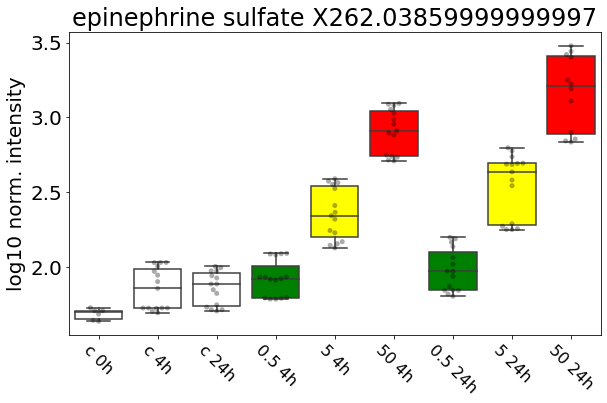

<Figure size 648x432 with 0 Axes>

In [ ]:
matplotlib.pyplot.figure(figsize=(9, 6))

g = seaborn.boxplot(data=plotting_values)
h = seaborn.swarmplot(data=plotting_values, color='black', alpha=1/3)

g.set(ylabel='log10 norm. intensity', title='{} {}'.format(target, working_peak_mz))
for i in range(len(g.artists)):
    g.artists[i].set_facecolor(condition_colors[i])
matplotlib.pyplot.xticks(list(range(len(condition_colors))), condition_labels, fontsize=16, rotation=-45)
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()
matplotlib.pyplot.clf()

# Visualization of all samples

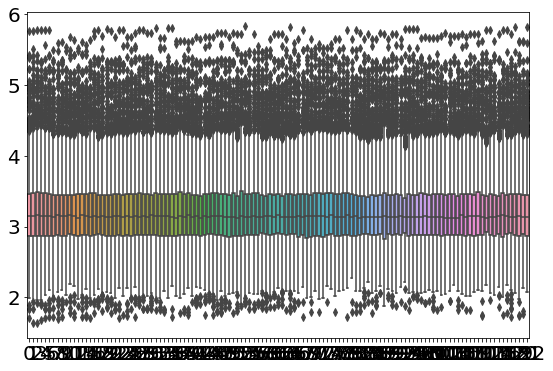

(1230, 123)


In [ ]:
tdf = wdf.transpose()
tdf.head()

tdf.drop(['Treatment', 'Time', 'Replicate'], axis=0, inplace=True)
tdf.head()

matplotlib.pyplot.figure(figsize=(9, 6))
seaborn.boxplot(data=tdf)
matplotlib.pyplot.show()
print(tdf.shape)

In [ ]:
wdf.head()

,Treatment,Time,Replicate,X59.01097,X61.017890000000001,X67.016220000000004,X74.021450000000002,X77.052040000000005,X77.052049999999994,X78.956580000000002,X78.956770000000006,X79.955420000000004,X80.962869999999995,X80.962720000000004,X82.951819999999998,X84.006739999999994,X84.043059999999997,X84.949100000000001,X85.027289999999994,X85.027019999999993,X85.027270000000001,X86.991519999999994,X87.006460000000004,X88.037970000000001,X88.037940000000006,X88.038039999999995,X88.03792,X89.022130000000004,X89.022099999999995,X89.040549999999996,X92.032160000000005,X92.031949999999995,X92.925600000000003,X93.043189999999996,X94.922759999999997,X96.919939999999997,X96.965789999999998,X96.967179999999999,X96.957989999999995,X96.965829999999997,...,X885.56862999999998,X885.57101,X886.53539000000001,X886.55880999999999,X886.57330999999999,X893.19449999999995,X893.21762000000001,X894.19538999999997,X894.21055000000001,X894.86288000000002,X906.21198000000004,X906.23701000000005,X918.79764999999998,X918.81568000000004,X918.83290999999997,X928.81326000000001,X928.82665999999995,X928.85361999999998,X928.86716999999999,X932.19215999999994,X932.20804999999996,X957.19478000000004,X957.21433999999999,X957.22663,X962.81850999999995,X962.83609000000001,X962.85298,X962.86944000000005,X968.30682999999999,X970.29764,X970.31845999999996,X970.33735000000001,X972.28162999999995,X986.81443999999999,X996.20851000000005,X996.78913999999997,X996.80704000000003,X996.82538,X996.84303,X996.86003000000005
0,EGM,0.0,0.0,2.731190,3.039996,2.498900,3.146793,2.926058,3.101473,4.249783,3.659928,2.675828,2.698426,2.835321,3.263095,3.015066,2.938611,2.771732,2.994916,2.569723,2.977499,3.331975,2.662741,3.665733,3.645038,2.769425,2.743793,4.397969,3.612091,3.062474,3.608017,3.098851,3.949611,2.609377,3.924130,3.195544,4.520370,4.703177,2.949756,4.252155,...,3.684713,3.504004,3.118662,3.310416,3.110021,3.646444,3.556255,2.969109,2.971801,3.184817,2.769092,2.892342,3.024038,3.064213,3.085544,3.635307,3.859158,3.857018,3.728960,3.087690,3.087883,3.428445,3.493868,3.400716,3.214216,3.334671,3.384709,3.415102,2.978815,3.022200,3.021206,2.995128,3.012682,3.068779,3.026200,3.681500,3.728084,3.902864,3.798414,3.779298
1,EGM,0.0,1.0,2.577060,2.966918,2.478636,3.080018,2.975931,3.142122,4.154512,3.619230,2.579870,2.562354,2.487779,3.258477,2.886799,2.854834,2.756858,3.007140,2.691261,3.068997,3.254947,2.539483,3.745788,3.727281,2.766418,2.712809,4.476157,3.668902,3.185888,3.538519,3.105857,3.923285,2.471512,4.182124,3.390994,4.219277,4.737366,2.993527,4.222383,...,3.625102,3.257475,2.969984,2.943847,2.821723,3.572133,3.534212,2.957405,2.959623,3.138686,2.805983,2.881742,3.038560,3.072207,3.068547,3.562690,3.816319,3.637790,3.717931,3.045000,3.049544,3.361241,3.383137,3.186481,3.128215,3.269217,3.395243,3.347042,3.103678,3.182975,3.197100,3.191962,3.090010,3.086108,2.856756,3.666367,3.817882,3.767177,3.784470,3.692333
2,EGM,0.0,2.0,2.567796,3.102377,2.315301,3.174088,3.080577,3.078214,3.950247,3.553190,2.447427,2.567267,2.467664,3.299520,2.868828,2.944417,2.891972,2.964754,2.616670,2.956515,3.345296,2.543528,3.662276,3.662167,2.855282,2.924238,4.572164,3.640099,3.137590,3.662951,3.321059,4.618832,2.497167,4.263248,3.499691,4.645017,4.724440,2.949756,4.259571,...,3.372456,3.223758,3.059874,3.043612,2.866050,3.409097,3.457334,2.832361,2.832637,3.139151,2.979729,3.026377,3.250336,3.299959,3.271043,3.775912,3.706156,3.971052,3.853376,2.860173,2.848091,3.188977,3.151786,3.090118,3.307722,3.408314,3.476060,3.459793,3.107535,3.193450,3.201853,3.251763,3.087607,3.325044,2.495992,3.780564,3.908326,3.861871,3.913619,3.892816
3,EGM,0.0,3.0,2.700993,3.041685,2.328574,3.091159,2.993070,3.046918,4.165901,3.546743,2.492790,2.705565,2.633503,3.303501,2.936790,3.100368,2.895259,3.112989,2.514703,2.908327,3.495694,2.696874,3.828928,3.827009,2.881977,2.872404,4.615308,3.755558,3.043079,3.613132,3.223012,4.592933,2.670872,3.749708,3.376602,4.460777,4.687126,2.928184,4.299938,...,3.057176,3.492650,3.

In [ ]:
# Separating out the features
x = wdf.loc[:, peak_names].values

sub4 = wdf[wdf['Time'] == 4]
x4 = sub4.loc[:, peak_names].values

sub24 = wdf[wdf['Time'] == 24]
x24 = sub24.loc[:, peak_names].values

print(x[:3])

[[2.73119002 3.03999643 2.49889979 ... 3.90286354 3.79841371 3.77929788]
 [2.57705968 2.96691755 2.47863587 ... 3.76717719 3.78446988 3.69233337]
 [2.56779611 3.10237684 2.31530088 ... 3.86187114 3.91361893 3.89281611]]


In [ ]:
# Standardizing the features
x = sklearn.preprocessing.StandardScaler().fit_transform(x)
x4 = sklearn.preprocessing.StandardScaler().fit_transform(x4)
x24 = sklearn.preprocessing.StandardScaler().fit_transform(x24)
x[:3]

array([[ 0.47671593,  0.3518314 , -0.61884887, ...,  1.46534957,
         0.50069521,  0.54273793],
       [-1.17237781, -0.45311811, -0.72210196, ...,  0.00453192,
         0.35610128, -0.32833978],
       [-1.27149199,  1.03893931, -1.5543615 , ...,  1.02401982,
         1.69534362,  1.67979031]])

## PCA for all samples

In [ ]:
pca = sklearn.decomposition.PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principal_df = pandas.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])

print(principal_df.shape)
principal_df.head()

(123, 2)


,PC1,PC2
0,3.693296,6.491065
1,-2.834521,-2.564014
2,-4.128783,-15.184289
3,-2.565232,-4.151022
4,11.313781,-5.972853


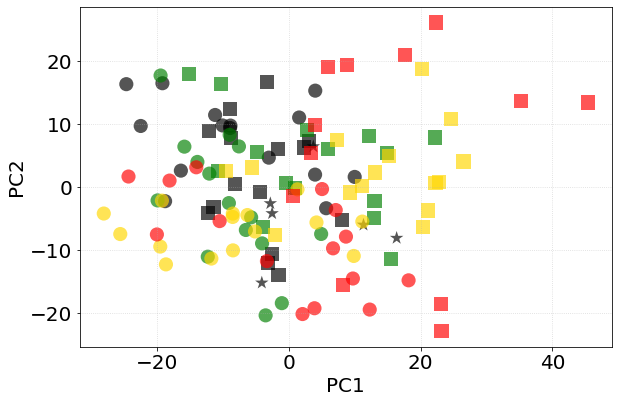

In [ ]:
matplotlib.pyplot.figure(figsize=(9, 6))

for i in range(len(wdf.index)):

  # colors
  if wdf.iloc[i]['Treatment'] == 'EGM':
    plotting_color = 'black'
  elif wdf.iloc[i]['Treatment'] == '1.0':
    plotting_color = 'green'
  elif wdf.iloc[i]['Treatment'] == '10.0':
    plotting_color = 'gold'
  elif wdf.iloc[i]['Treatment'] == '100.0':
    plotting_color = 'red'
  else:
    print('error')

  # markers
  if wdf.iloc[i]['Time'] == 0:
    plotting_marker = '*'
  elif wdf.iloc[i]['Time'] == 4:
    plotting_marker = 'o'
  elif wdf.iloc[i]['Time'] == 24:
    plotting_marker = 's'
  else:
    print('error')

  # position
  posx = principal_df.iloc[i]['PC1']
  posy = principal_df.iloc[i]['PC2']

  # plot
  matplotlib.pyplot.scatter(posx, posy, s=200, c=plotting_color, alpha=2/3, ec=None, marker=plotting_marker)

matplotlib.pyplot.grid(alpha=1/2, ls=':')
matplotlib.pyplot.xlabel('PC1')
matplotlib.pyplot.ylabel('PC2')
matplotlib.pyplot.tight_layout()

#matplotlib.show()
#matplotlib.pyplot.savefig('/content/drive/MyDrive/hi/research/huvec/results/untargeted/figures/pca_all.svg')
#matplotlib.pyplot.clf()

## tSNSE of all samples

In [ ]:
embedding = sklearn.manifold.TSNE(n_components=2, init='pca', verbose=1, perplexity=15, learning_rate=10, metric='cosine', early_exaggeration=3, method='exact').fit_transform(x)

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 123 / 123
[t-SNE] Mean sigma: 0.260131
[t-SNE] KL divergence after 250 iterations with early exaggeration: 7.654512
[t-SNE] KL divergence after 1000 iterations: 0.521172


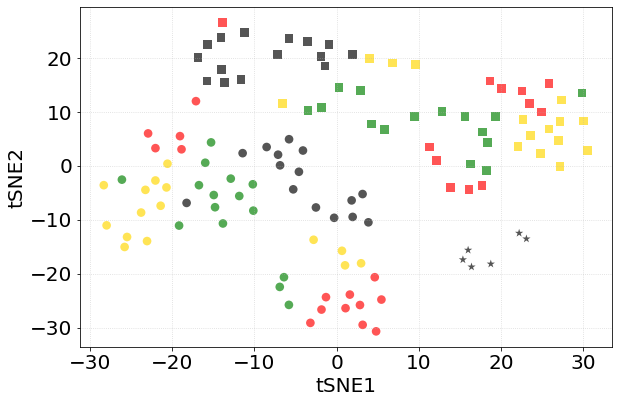

In [ ]:
matplotlib.pyplot.figure(figsize=(9, 6))

for i in range(len(wdf.index)):

  # colors
  if wdf.iloc[i]['Treatment'] == 'EGM':
    plotting_color = 'black'
  elif wdf.iloc[i]['Treatment'] == '1.0':
    plotting_color = 'green'
  elif wdf.iloc[i]['Treatment'] == '10.0':
    plotting_color = 'gold'
  elif wdf.iloc[i]['Treatment'] == '100.0':
    plotting_color = 'red'
  else:
    print('error')

  # markers
  if wdf.iloc[i]['Time'] == 0:
    plotting_marker = '*'
  elif wdf.iloc[i]['Time'] == 4:
    plotting_marker = 'o'
  elif wdf.iloc[i]['Time'] == 24:
    plotting_marker = 's'
  else:
    print('error')

  # position
  posx = embedding[i][0]
  posy = embedding[i][1]

  # plot
  matplotlib.pyplot.scatter(posx, posy, s=75, c=plotting_color, alpha=2/3, ec=None, marker=plotting_marker)

matplotlib.pyplot.grid(alpha=1/2, ls=':')
matplotlib.pyplot.xlabel('tSNE1')
matplotlib.pyplot.ylabel('tSNE2')
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

## UMAP of all samples

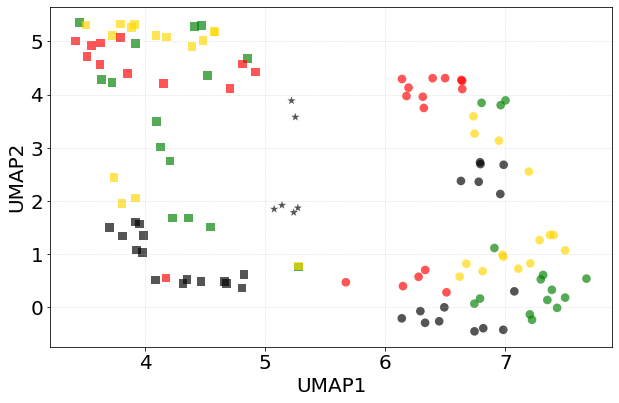

In [ ]:
reducer = umap.UMAP(metric='cosine', n_neighbors=15, min_dist=0)
umap_embedding = reducer.fit_transform(x)

matplotlib.pyplot.figure(figsize=(9, 6))

for i in range(len(wdf.index)):

  # colors
  if wdf.iloc[i]['Treatment'] == 'EGM':
    plotting_color = 'black'
  elif wdf.iloc[i]['Treatment'] == '1.0':
    plotting_color = 'green'
  elif wdf.iloc[i]['Treatment'] == '10.0':
    plotting_color = 'gold'
  elif wdf.iloc[i]['Treatment'] == '100.0':
    plotting_color = 'red'
  else:
    print('error')

  # markers
  if wdf.iloc[i]['Time'] == 0:
    plotting_marker = '*'
  elif wdf.iloc[i]['Time'] == 4:
    plotting_marker = 'o'
  elif wdf.iloc[i]['Time'] == 24:
    plotting_marker = 's'
  else:
    print('error')

  # position
  posx = umap_embedding[i][0]
  posy = umap_embedding[i][1]

  # plot
  matplotlib.pyplot.scatter(posx, posy, s=75, c=plotting_color, alpha=2/3, ec=None, marker=plotting_marker)

matplotlib.pyplot.grid(alpha=1/2, ls=':')
matplotlib.pyplot.xlabel('UMAP1')
matplotlib.pyplot.ylabel('UMAP2')
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()
# really need to do it at separate times two figures. go for it

# Visualization for 4 h samples

## PCA for 4 h samples

In [ ]:
pca = sklearn.decomposition.PCA(n_components=2)
principalComponents = pca.fit_transform(x4)
principal_df = pandas.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])

print(principal_df.shape)
principal_df.head()

(60, 2)


,PC1,PC2
0,-8.717030,17.628532
1,-10.111786,14.720600
2,8.862420,13.943216
3,-11.353585,9.871117
4,-9.736215,11.123917


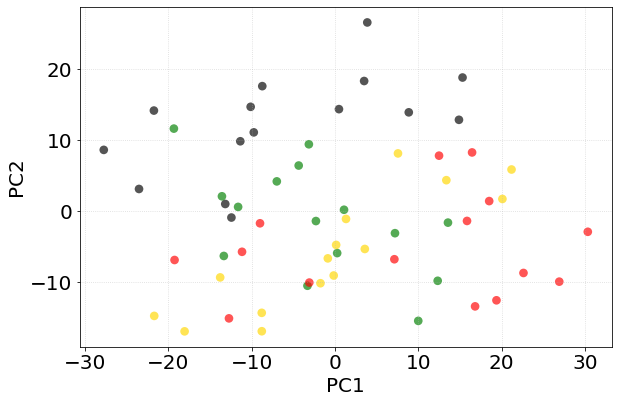

In [ ]:
matplotlib.pyplot.figure(figsize=(9, 6))

for i in range(len(sub4.index)):

  # colors
  if sub4.iloc[i]['Treatment'] == 'EGM':
    plotting_color = 'black'
  elif sub4.iloc[i]['Treatment'] == '1.0':
    plotting_color = 'green'
  elif sub4.iloc[i]['Treatment'] == '10.0':
    plotting_color = 'gold'
  elif sub4.iloc[i]['Treatment'] == '100.0':
    plotting_color = 'red'
  else:
    print('error')

  # markers
  if sub4.iloc[i]['Time'] == 0:
    plotting_marker = '*'
  elif sub4.iloc[i]['Time'] == 4:
    plotting_marker = 'o'
  elif sub4.iloc[i]['Time'] == 24:
    plotting_marker = 's'
  else:
    print('error')

  # position
  posx = principal_df.iloc[i]['PC1']
  posy = principal_df.iloc[i]['PC2']

  # plot
  matplotlib.pyplot.scatter(posx, posy, s=75, c=plotting_color, alpha=2/3, ec=None, marker=plotting_marker)

matplotlib.pyplot.grid(alpha=1/2, ls=':')
matplotlib.pyplot.xlabel('PC1')
matplotlib.pyplot.ylabel('PC2')
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

## tSNE for 4 h samples

[t-SNE] Computing 46 nearest neighbors...
[t-SNE] Indexed 60 samples in 0.000s...
[t-SNE] Computed neighbors for 60 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 60 / 60
[t-SNE] Mean sigma: 0.286468
[t-SNE] KL divergence after 250 iterations with early exaggeration: 93.757126
[t-SNE] KL divergence after 1000 iterations: 0.389881


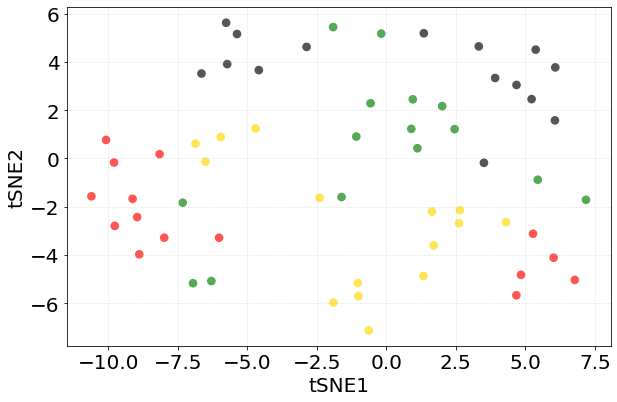

In [ ]:
embedding = sklearn.manifold.TSNE(n_components=2, init='pca', verbose=1, perplexity=15, learning_rate=10, metric='cosine', early_exaggeration=20).fit_transform(x4)

matplotlib.pyplot.figure(figsize=(9, 6))

for i in range(len(sub4.index)):

  # colors
  if sub4.iloc[i]['Treatment'] == 'EGM':
    plotting_color = 'black'
  elif sub4.iloc[i]['Treatment'] == '1.0':
    plotting_color = 'green'
  elif sub4.iloc[i]['Treatment'] == '10.0':
    plotting_color = 'gold'
  elif sub4.iloc[i]['Treatment'] == '100.0':
    plotting_color = 'red'
  else:
    print('error')

  # markers
  if sub4.iloc[i]['Time'] == 0:
    plotting_marker = '*'
  elif sub4.iloc[i]['Time'] == 4:
    plotting_marker = 'o'
  elif sub4.iloc[i]['Time'] == 24:
    plotting_marker = 's'
  else:
    print('error')

  # position
  posx = embedding[i][0]
  posy = embedding[i][1]

  # plot
  matplotlib.pyplot.scatter(posx, posy, s=75, c=plotting_color, alpha=2/3, ec=None, marker=plotting_marker)

matplotlib.pyplot.grid(alpha=1/2, ls=':')
matplotlib.pyplot.xlabel('tSNE1')
matplotlib.pyplot.ylabel('tSNE2')
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

## UMAP for 4 h samples

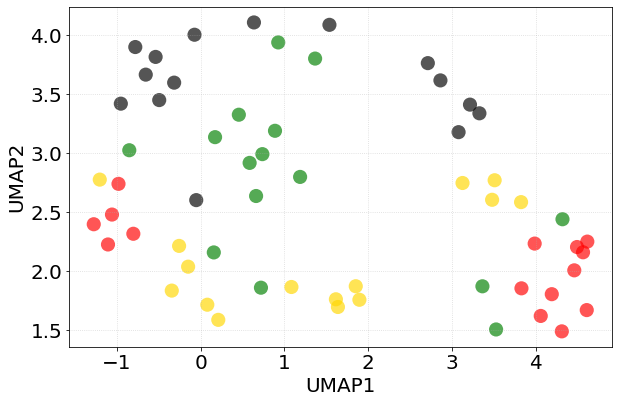

In [ ]:
reducer = umap.UMAP(metric='cosine', n_neighbors=15, min_dist=0, random_state=0)
umap_embedding = reducer.fit_transform(x4)

matplotlib.pyplot.figure(figsize=(9, 6))

for i in range(len(sub4.index)):

  # colors
  if sub4.iloc[i]['Treatment'] == 'EGM':
    plotting_color = 'black'
  elif sub4.iloc[i]['Treatment'] == '1.0':
    plotting_color = 'green'
  elif sub4.iloc[i]['Treatment'] == '10.0':
    plotting_color = 'gold'
  elif sub4.iloc[i]['Treatment'] == '100.0':
    plotting_color = 'red'
  else:
    print('error')

  # markers
  if sub4.iloc[i]['Time'] == 0:
    plotting_marker = '*'
  elif sub4.iloc[i]['Time'] == 4:
    plotting_marker = 'o'
  elif sub4.iloc[i]['Time'] == 24:
    plotting_marker = 's'
  else:
    print('error')

  # position
  posx = umap_embedding[i][0]
  posy = umap_embedding[i][1]

  # plot
  matplotlib.pyplot.scatter(posx, posy, s=200, c=plotting_color, alpha=2/3, ec=None, marker=plotting_marker)

matplotlib.pyplot.grid(alpha=1/2, ls=':')
matplotlib.pyplot.xlabel('UMAP1')
matplotlib.pyplot.ylabel('UMAP2')
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

# Visualization for 24 h samples

## UMAP for 24 h samples

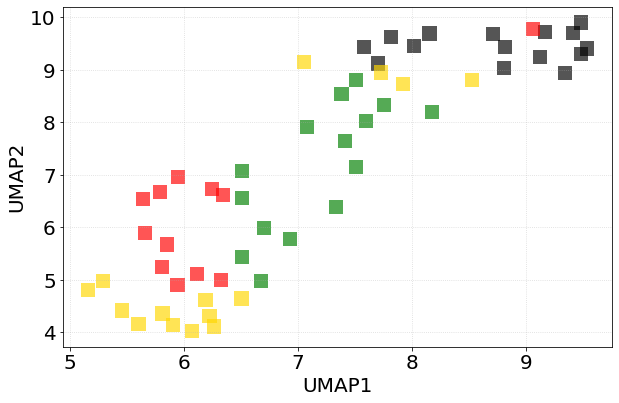

In [ ]:
reducer = umap.UMAP(metric='cosine', n_neighbors=15, min_dist=0, random_state=1)
umap_embedding = reducer.fit_transform(x24)

matplotlib.pyplot.figure(figsize=(9, 6))

for i in range(len(sub24.index)):

  # colors
  if sub24.iloc[i]['Treatment'] == 'EGM':
    plotting_color = 'black'
  elif sub24.iloc[i]['Treatment'] == '1.0':
    plotting_color = 'green'
  elif sub24.iloc[i]['Treatment'] == '10.0':
    plotting_color = 'gold'
  elif sub24.iloc[i]['Treatment'] == '100.0':
    plotting_color = 'red'
  else:
    print('error')

  # markers
  if sub24.iloc[i]['Time'] == 0:
    plotting_marker = '*'
  elif sub24.iloc[i]['Time'] == 4:
    plotting_marker = 'o'
  elif sub24.iloc[i]['Time'] == 24:
    plotting_marker = 's'
  else:
    print('error')

  # position
  posx = umap_embedding[i][0]
  posy = umap_embedding[i][1]

  # plot
  matplotlib.pyplot.scatter(posx, posy, s=200, c=plotting_color, alpha=2/3, ec=None, marker=plotting_marker)

matplotlib.pyplot.grid(alpha=1/2, ls=':')
matplotlib.pyplot.xlabel('UMAP1')
matplotlib.pyplot.ylabel('UMAP2')
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

# Heatmap of responding features

consider
plot distributions of mutual information and F-test on scaled log2 values for 0, 0.5, 5, adn 50 uM. Make sure that there is at least log2 FC > 1.

plot the log2FC to make sure the distribution makes sense.




In [ ]:
print(wdf.shape)
wdf.head()

(123, 1233)


,Treatment,Time,Replicate,X59.01097,X61.017890000000001,X67.016220000000004,X74.021450000000002,X77.052040000000005,X77.052049999999994,X78.956580000000002,X78.956770000000006,X79.955420000000004,X80.962869999999995,X80.962720000000004,X82.951819999999998,X84.006739999999994,X84.043059999999997,X84.949100000000001,X85.027289999999994,X85.027019999999993,X85.027270000000001,X86.991519999999994,X87.006460000000004,X88.037970000000001,X88.037940000000006,X88.038039999999995,X88.03792,X89.022130000000004,X89.022099999999995,X89.040549999999996,X92.032160000000005,X92.031949999999995,X92.925600000000003,X93.043189999999996,X94.922759999999997,X96.919939999999997,X96.965789999999998,X96.967179999999999,X96.957989999999995,X96.965829999999997,...,X885.56862999999998,X885.57101,X886.53539000000001,X886.55880999999999,X886.57330999999999,X893.19449999999995,X893.21762000000001,X894.19538999999997,X894.21055000000001,X894.86288000000002,X906.21198000000004,X906.23701000000005,X918.79764999999998,X918.81568000000004,X918.83290999999997,X928.81326000000001,X928.82665999999995,X928.85361999999998,X928.86716999999999,X932.19215999999994,X932.20804999999996,X957.19478000000004,X957.21433999999999,X957.22663,X962.81850999999995,X962.83609000000001,X962.85298,X962.86944000000005,X968.30682999999999,X970.29764,X970.31845999999996,X970.33735000000001,X972.28162999999995,X986.81443999999999,X996.20851000000005,X996.78913999999997,X996.80704000000003,X996.82538,X996.84303,X996.86003000000005
0,EGM,0.0,0.0,2.731190,3.039996,2.498900,3.146793,2.926058,3.101473,4.249783,3.659928,2.675828,2.698426,2.835321,3.263095,3.015066,2.938611,2.771732,2.994916,2.569723,2.977499,3.331975,2.662741,3.665733,3.645038,2.769425,2.743793,4.397969,3.612091,3.062474,3.608017,3.098851,3.949611,2.609377,3.924130,3.195544,4.520370,4.703177,2.949756,4.252155,...,3.684713,3.504004,3.118662,3.310416,3.110021,3.646444,3.556255,2.969109,2.971801,3.184817,2.769092,2.892342,3.024038,3.064213,3.085544,3.635307,3.859158,3.857018,3.728960,3.087690,3.087883,3.428445,3.493868,3.400716,3.214216,3.334671,3.384709,3.415102,2.978815,3.022200,3.021206,2.995128,3.012682,3.068779,3.026200,3.681500,3.728084,3.902864,3.798414,3.779298
1,EGM,0.0,1.0,2.577060,2.966918,2.478636,3.080018,2.975931,3.142122,4.154512,3.619230,2.579870,2.562354,2.487779,3.258477,2.886799,2.854834,2.756858,3.007140,2.691261,3.068997,3.254947,2.539483,3.745788,3.727281,2.766418,2.712809,4.476157,3.668902,3.185888,3.538519,3.105857,3.923285,2.471512,4.182124,3.390994,4.219277,4.737366,2.993527,4.222383,...,3.625102,3.257475,2.969984,2.943847,2.821723,3.572133,3.534212,2.957405,2.959623,3.138686,2.805983,2.881742,3.038560,3.072207,3.068547,3.562690,3.816319,3.637790,3.717931,3.045000,3.049544,3.361241,3.383137,3.186481,3.128215,3.269217,3.395243,3.347042,3.103678,3.182975,3.197100,3.191962,3.090010,3.086108,2.856756,3.666367,3.817882,3.767177,3.784470,3.692333
2,EGM,0.0,2.0,2.567796,3.102377,2.315301,3.174088,3.080577,3.078214,3.950247,3.553190,2.447427,2.567267,2.467664,3.299520,2.868828,2.944417,2.891972,2.964754,2.616670,2.956515,3.345296,2.543528,3.662276,3.662167,2.855282,2.924238,4.572164,3.640099,3.137590,3.662951,3.321059,4.618832,2.497167,4.263248,3.499691,4.645017,4.724440,2.949756,4.259571,...,3.372456,3.223758,3.059874,3.043612,2.866050,3.409097,3.457334,2.832361,2.832637,3.139151,2.979729,3.026377,3.250336,3.299959,3.271043,3.775912,3.706156,3.971052,3.853376,2.860173,2.848091,3.188977,3.151786,3.090118,3.307722,3.408314,3.476060,3.459793,3.107535,3.193450,3.201853,3.251763,3.087607,3.325044,2.495992,3.780564,3.908326,3.861871,3.913619,3.892816
3,EGM,0.0,3.0,2.700993,3.041685,2.328574,3.091159,2.993070,3.046918,4.165901,3.546743,2.492790,2.705565,2.633503,3.303501,2.936790,3.100368,2.895259,3.112989,2.514703,2.908327,3.495694,2.696874,3.828928,3.827009,2.881977,2.872404,4.615308,3.755558,3.043079,3.613132,3.223012,4.592933,2.670872,3.749708,3.376602,4.460777,4.687126,2.928184,4.299938,...,3.057176,3.492650,3.

## determine dose-responding features


In [ ]:
delta_threshold = numpy.log10(2)
p_value_threshold = 0.05
correlations_df = pandas.DataFrame(columns=['peak name', 'log2FC', 'P value', 'r value'])

working_times = [4, 24]
#working_times = [4]
for wt in working_times:
  sub = wdf[wdf['Time'] == wt]
  print(sub.shape)

  distribution_of_fc = []
  for peak_name in peak_names:
    x = [] ; y = []
    for index, row in sub.iterrows():

      treatment = row['Treatment']
      if treatment == 'EGM':
        x.append(0)
      elif treatment == '1.0':
        x.append(1)
      elif treatment == '10.0':
        x.append(2)
      elif treatment == '100.0':
        x.append(3)
      else:
        raise ValueError('error')

      value = float(row[peak_name])
      y.append(value)
    
    # linear regression
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    ypred = slope*numpy.array(x) + intercept
    delta = numpy.abs(numpy.max(ypred) - numpy.min(ypred))
    log2FC = numpy.log2(10**delta)
    if r_value < 0:
      log2FC = -log2FC
    
    new_row = {'time':wt, 'peak name':peak_name, 'log2FC':log2FC, 'P value':p_value, 'r value':r_value}
    correlations_df = correlations_df.append(new_row, ignore_index=True)
    
    if (delta > delta_threshold) & (p_value < p_value_threshold):
      print(peak_name, delta, p_value, r_value)
  print()

correlations_df.head()

(60, 1233)
X92.925600000000003 0.39095394048784726 6.613829788621385e-05 0.49170460864282245
X133.98987 0.30805074768585694 0.0006437534260159862 0.4281363912372645
X146.07991000000001 0.3172422882345902 3.99234217308681e-05 -0.5042620087364156
X262.03859999999997 1.0787045642517978 2.2405680834192577e-23 0.9064180960735608
X276.05410000000001 1.1434030356201443 1.6597029625155161e-25 0.9215605121101376
X276.05387000000002 1.030763642688598 1.5085898777319069e-25 0.9218284440821257
X306.07519000000002 0.37000501457442825 4.059147640446966e-06 -0.5556327434976769
X328.05739999999997 0.35447622683381486 0.00013578237592335747 -0.4729211478325389
X329.06038999999998 0.3142660249759617 5.1656169279036624e-06 -0.5505963315417898
X360.08832000000001 0.3363583465386246 2.482280443695937e-06 -0.565659561321259

(57, 1233)
X96.919939999999997 0.30890471497821625 0.00016546637048530096 -0.4786936329822602
X175.02331000000001 0.8658486650765549 1.0507720169451485e-15 0.8321732941508257
X199.16800

,peak name,log2FC,P value,r value,time
0,X59.01097,0.160578,0.092914,0.218881,4.0
1,X61.017890000000001,0.178149,0.050297,0.253887,4.0
2,X67.016220000000004,-0.108899,0.631602,-0.063167,4.0
3,X74.021450000000002,0.293160,0.000545,0.433248,4.0
4,X77.052040000000005,0.222653,0.006787,0.345907,4.0


In [ ]:
correlations_df[correlations_df['peak name'] == 'X276.05387000000002']

,peak name,log2FC,P value,r value,time
394,X276.05387000000002,3.424123,1.508590e-25,0.921828,4.0
1624,X276.05387000000002,4.607447,5.899145e-25,0.926148,24.0


In [ ]:
# add BH correction
all_p_values = correlations_df['P value'].to_list()
storage = statsmodels.stats.multitest.multipletests(all_p_values, alpha=0.1, method='fdr_bh')
corrected = storage[1]
correlations_df['corrected P value'] = corrected
correlations_df

,peak name,log2FC,P value,r value,time,corrected P value
0,X59.01097,0.160578,0.092914,0.218881,4.0,0.195190
1,X61.017890000000001,0.178149,0.050297,0.253887,4.0,0.127425
2,X67.016220000000004,-0.108899,0.631602,-0.063167,4.0,0.733935
3,X74.021450000000002,0.293160,0.000545,0.433248,4.0,0.005115
4,X77.052040000000005,0.222653,0.006787,0.345907,4.0,0.029566
...,...,...,...,...,...,...
2455,X996.78913999999997,-0.155759,0.292379,-0.141899,24.0,0.433808
2456,X996.80704000000003,-0.162769,0.233404,-0.160365,24.0,0.368296
2457,X996.82538,-0.207772,0.076811,-0.236279,24.0,0.171778
2458,X996.84303,-0.108669,0.376501,-0.119361,24.0,0.513695


In [ ]:
mean = numpy.mean(correlations_df['log2FC'])
std = numpy.std(correlations_df['log2FC'])
threshold = mean + 1.959964*std
print(threshold)

dose_t = correlations_df[(numpy.abs(correlations_df['log2FC']) > threshold) & (correlations_df['corrected P value'] < 0.05)]

print(threshold)
print(dose_t.shape)
dose_t.head()

0.8314568965620486
0.8314568965620486
(63, 6)


,peak name,log2FC,P value,r value,time,corrected P value
29,X92.925600000000003,1.298721,6.613830e-05,0.491705,4.0,0.001139
31,X94.922759999999997,0.895814,9.782844e-03,0.331020,4.0,0.038382
33,X96.965789999999998,0.988130,8.079288e-03,0.338896,4.0,0.033180
37,X97.009529999999998,-0.980578,3.961084e-03,-0.366632,4.0,0.020398
41,X102.05362,-0.926010,2.800367e-07,-0.606523,4.0,0.000025


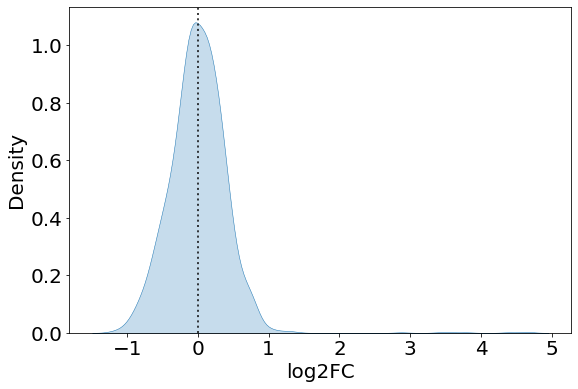

In [ ]:
# histogram of log2FC
matplotlib.pyplot.figure(figsize=(9, 6))
g = seaborn.kdeplot(data=correlations_df['log2FC'], fill=True, palette="tab10", alpha=1/4, linewidth=1/2)
matplotlib.pyplot.axvline(x=0, lw=2, alpha=3/4, color='black', ls=':')
matplotlib.pyplot.show()

## generate boxplots & heatmap

In [ ]:
wdf.head()

,Treatment,Time,Replicate,X59.01097,X61.017890000000001,X67.016220000000004,X74.021450000000002,X77.052040000000005,X77.052049999999994,X78.956580000000002,X78.956770000000006,X79.955420000000004,X80.962869999999995,X80.962720000000004,X82.951819999999998,X84.006739999999994,X84.043059999999997,X84.949100000000001,X85.027289999999994,X85.027019999999993,X85.027270000000001,X86.991519999999994,X87.006460000000004,X88.037970000000001,X88.037940000000006,X88.038039999999995,X88.03792,X89.022130000000004,X89.022099999999995,X89.040549999999996,X92.032160000000005,X92.031949999999995,X92.925600000000003,X93.043189999999996,X94.922759999999997,X96.919939999999997,X96.965789999999998,X96.967179999999999,X96.957989999999995,X96.965829999999997,...,X885.56862999999998,X885.57101,X886.53539000000001,X886.55880999999999,X886.57330999999999,X893.19449999999995,X893.21762000000001,X894.19538999999997,X894.21055000000001,X894.86288000000002,X906.21198000000004,X906.23701000000005,X918.79764999999998,X918.81568000000004,X918.83290999999997,X928.81326000000001,X928.82665999999995,X928.85361999999998,X928.86716999999999,X932.19215999999994,X932.20804999999996,X957.19478000000004,X957.21433999999999,X957.22663,X962.81850999999995,X962.83609000000001,X962.85298,X962.86944000000005,X968.30682999999999,X970.29764,X970.31845999999996,X970.33735000000001,X972.28162999999995,X986.81443999999999,X996.20851000000005,X996.78913999999997,X996.80704000000003,X996.82538,X996.84303,X996.86003000000005
0,EGM,0.0,0.0,2.731190,3.039996,2.498900,3.146793,2.926058,3.101473,4.249783,3.659928,2.675828,2.698426,2.835321,3.263095,3.015066,2.938611,2.771732,2.994916,2.569723,2.977499,3.331975,2.662741,3.665733,3.645038,2.769425,2.743793,4.397969,3.612091,3.062474,3.608017,3.098851,3.949611,2.609377,3.924130,3.195544,4.520370,4.703177,2.949756,4.252155,...,3.684713,3.504004,3.118662,3.310416,3.110021,3.646444,3.556255,2.969109,2.971801,3.184817,2.769092,2.892342,3.024038,3.064213,3.085544,3.635307,3.859158,3.857018,3.728960,3.087690,3.087883,3.428445,3.493868,3.400716,3.214216,3.334671,3.384709,3.415102,2.978815,3.022200,3.021206,2.995128,3.012682,3.068779,3.026200,3.681500,3.728084,3.902864,3.798414,3.779298
1,EGM,0.0,1.0,2.577060,2.966918,2.478636,3.080018,2.975931,3.142122,4.154512,3.619230,2.579870,2.562354,2.487779,3.258477,2.886799,2.854834,2.756858,3.007140,2.691261,3.068997,3.254947,2.539483,3.745788,3.727281,2.766418,2.712809,4.476157,3.668902,3.185888,3.538519,3.105857,3.923285,2.471512,4.182124,3.390994,4.219277,4.737366,2.993527,4.222383,...,3.625102,3.257475,2.969984,2.943847,2.821723,3.572133,3.534212,2.957405,2.959623,3.138686,2.805983,2.881742,3.038560,3.072207,3.068547,3.562690,3.816319,3.637790,3.717931,3.045000,3.049544,3.361241,3.383137,3.186481,3.128215,3.269217,3.395243,3.347042,3.103678,3.182975,3.197100,3.191962,3.090010,3.086108,2.856756,3.666367,3.817882,3.767177,3.784470,3.692333
2,EGM,0.0,2.0,2.567796,3.102377,2.315301,3.174088,3.080577,3.078214,3.950247,3.553190,2.447427,2.567267,2.467664,3.299520,2.868828,2.944417,2.891972,2.964754,2.616670,2.956515,3.345296,2.543528,3.662276,3.662167,2.855282,2.924238,4.572164,3.640099,3.137590,3.662951,3.321059,4.618832,2.497167,4.263248,3.499691,4.645017,4.724440,2.949756,4.259571,...,3.372456,3.223758,3.059874,3.043612,2.866050,3.409097,3.457334,2.832361,2.832637,3.139151,2.979729,3.026377,3.250336,3.299959,3.271043,3.775912,3.706156,3.971052,3.853376,2.860173,2.848091,3.188977,3.151786,3.090118,3.307722,3.408314,3.476060,3.459793,3.107535,3.193450,3.201853,3.251763,3.087607,3.325044,2.495992,3.780564,3.908326,3.861871,3.913619,3.892816
3,EGM,0.0,3.0,2.700993,3.041685,2.328574,3.091159,2.993070,3.046918,4.165901,3.546743,2.492790,2.705565,2.633503,3.303501,2.936790,3.100368,2.895259,3.112989,2.514703,2.908327,3.495694,2.696874,3.828928,3.827009,2.881977,2.872404,4.615308,3.755558,3.043079,3.613132,3.223012,4.592933,2.670872,3.749708,3.376602,4.460777,4.687126,2.928184,4.299938,...,3.057176,3.492650,3.

In [ ]:
relevant_peaks = list(set(dose_t['peak name'].to_list()))
print(relevant_peaks[:5], len(relevant_peaks))

['X500.92164000000002', 'X133.98942', 'X794.40711999999996', 'X144.06457', 'X240.04947999999999'] 60


In [ ]:
# # generate boxplots on raw intensity
# for relevant_peak in relevant_peaks:

#   plotting_values = []
#   for condition in conditions:
#     treatment = condition[0]; timepoint = condition[1]
#     sub = wdf[(wdf['Treatment'] == treatment) & (wdf['Time'] == timepoint)][relevant_peak]
#     box = sub.values
#     plotting_values.append(box)
#     print('treatment {}, timepoint {}, shape {}'.format(treatment, timepoint, sub.shape))

#   matplotlib.pyplot.figure(figsize=(9, 6))
#   g = seaborn.boxplot(data=plotting_values)
#   h = seaborn.swarmplot(data=plotting_values, color='black', alpha=1/3)
#   g.set(ylabel='log10 norm. intensity', title='{}'.format(relevant_peak))
#   for i in range(len(g.artists)):
#     g.artists[i].set_facecolor(condition_colors[i])
#   matplotlib.pyplot.xticks(list(range(len(condition_colors))), condition_labels, fontsize=16, rotation=-45)
#   matplotlib.pyplot.tight_layout()

#   figure_path = '/content/drive/MyDrive/hi/research/huvec/results/untargeted/figures/boxplots/{}.svg'.format(relevant_peak) 
#   matplotlib.pyplot.savefig(figure_path)

In [ ]:
references = [(4, 'EGM'), (24, 'EGM')]
conditions = ['1.0', '10.0', '100.0']
pdf = pandas.DataFrame()


for peak_name in relevant_peaks:
  heatmap_values = []; all_boxplot_values = []
  for reference in references:
    for condition in conditions:

      denominator_values = wdf[(wdf['Time'] == reference[0]) & (wdf['Treatment'] == reference[1])][peak_name].values
      numerator_values = wdf[(wdf['Time'] == reference[0]) & (wdf['Treatment'] == condition)][peak_name].values

      log10FC = numpy.mean(numerator_values) - numpy.mean(denominator_values)
      log2FC = numpy.log2(10**log10FC)
      heatmap_values.append(log2FC)

      boxplot_values = numpy.log2(10**(numerator_values - numpy.mean(denominator_values)))
      all_boxplot_values.append(boxplot_values)

  pdf = pandas.concat((pdf, pandas.DataFrame({peak_name:heatmap_values})), axis=1)

  # generate figure of boxplots
  g = seaborn.boxplot(data=all_boxplot_values)
  h = seaborn.swarmplot(data=all_boxplot_values, color='black', alpha=1/3)
  g.set(ylabel='log2 rel. intensity', title='{}'.format(peak_name))
  b_colors = ['tab:green', 'gold', 'tab:red', 'tab:green', 'gold', 'tab:red']
  for i in range(len(g.artists)):
    g.artists[i].set_facecolor(b_colors[i])
  matplotlib.pyplot.grid(':', alpha=0.5)
  matplotlib.pyplot.tight_layout()
  figure_path = '/content/drive/MyDrive/hi/research/huvec/results/untargeted/figures/boxplots/{}.svg'.format(peak_name) 
  matplotlib.pyplot.savefig(figure_path)
  matplotlib.pyplot.clf()

print(pdf.shape)
pdf.head()

(6, 60)


,X500.92164000000002,X133.98942,X794.40711999999996,X144.06457,X240.04947999999999,X883.53687000000002,X162.83770000000001,X262.03859999999997,X883.50469999999996,X794.42385999999999,X160.05119999999999,X102.05362,X321.17365999999998,X329.06038999999998,X322.17590000000001,X441.25072999999998,X493.18281999999999,X562.60356999999999,X199.16800000000001,X323.16978,X736.13774000000001,X438.81929000000002,X485.279,X160.84058999999999,X133.98987,X883.55157999999994,X175.02331000000001,X218.10158000000001,X360.08832000000001,X353.04653999999999,X885.54012999999998,X797.51549,X307.07736,X397.22516999999999,X115.00147,X146.07991000000001,X166.08246,X279.16082999999998,X276.05387000000002,X883.52017999999998,X306.07519000000002,X96.919939999999997,X94.922759999999997,X560.60392999999999,X350.04056000000003,X272.79386,X173.10265000000001,X500.27357000000001,X92.925600000000003,X328.05739999999997,X96.965789999999998,X957.21433999999999,X321.17340000000002,X321.16253999999998,X272.08780000000002,X957.19478000000004,X459.32449000000003,X276.05410000000001,X283.05149999999998,X97.009529999999998
0,-0.450986,0.177647,0.494817,-0.324190,0.071110,-0.467314,0.680312,0.233545,-0.401530,0.441432,0.248863,-0.407943,0.036490,-0.403244,0.039240,0.235665,0.048448,0.578058,-0.217347,0.095747,0.491006,0.061581,0.256853,0.619095,0.327894,-0.510837,0.003126,-0.752395,-0.548610,-0.448343,-0.493951,-0.438642,-0.071332,0.328114,-0.038582,-0.808564,0.071142,-0.326795,0.304032,-0.488324,-0.322201,0.131543,0.523447,0.924272,-0.333139,0.784825,-0.440515,-0.347208,1.302138,-0.294119,0.417796,-0.171431,0.273868,0.302865,-0.369125,-0.241787,0.256032,0.133205,1.113663,-1.625257
1,-0.642441,0.112808,0.469856,-0.540060,0.160425,-0.802546,0.667558,1.665070,-0.684538,0.552105,0.260211,-0.517380,0.389321,-0.409124,0.378477,0.480701,0.327446,0.603364,-0.031241,0.735939,-0.691675,-0.073909,0.259298,0.824113,0.120017,-0.756169,-0.013754,-0.602723,-0.472062,-0.617255,-0.897410,-0.443705,-0.282837,0.469377,-0.021583,-0.787716,0.153239,0.799664,1.652036,-0.734844,-0.239050,-0.163627,0.425350,0.841890,-0.144866,0.943875,-0.284513,0.030199,1.295441,-0.285462,0.994065,-0.926199,0.545262,0.468293,-0.337504,-1.003259,-0.280032,1.961848,1.415994,-1.171668
2,-0.281300,1.059324,0.336244,-1.015238,0.082154,-0.927394,0.561739,3.504357,-0.973002,0.437386,0.430146,-0.992421,0.152470,-1.158006,0.178150,0.258212,-0.095261,0.496956,-0.003829,0.397604,0.225710,0.047184,0.307414,0.579906,1.206317,-0.945129,-0.384102,-1.003354,-1.267025,-0.180308,-0.851332,-0.963922,-0.896738,0.406069,-0.528581,-1.177901,0.018522,0.686503,3.355246,-1.022351,-1.393417,-0.047518,1.028047,0.737056,-1.055566,0.743682,-0.157829,-0.167091,1.445255,-1.311269,0.905833,-0.763394,0.755746,0.642873,-0.952965,-0.845186,0.094621,3.610788,0.519179,-1.240728
3,0.466293,0.342234,-0.271384,0.039214,-0.275028,-0.260973,0.122664,0.398993,-0.372592,-0.245329,0.102832,0.111967,0.263695,0.356946,0.206162,0.522513,-0.235458,-0.196772,0.214431,0.106473,-0.226701,-0.226050,0.481218,0.226434,0.318544,-0.216966,0.606065,-0.114541,-0.049619,1.319091,-0.394041,0.096125,0.418606,0.460085,0.661208,0.230510,-0.261877,-0.624210,0.546966,-0.275388,0.357178,-0.492042,0.249077,-0.335639,0.500595,-0.375447,0.771529,-0.115969,-0.750107,0.289119,-0.448531,-0.669376,0.243674,0.303839,0.342963,-0.666534,-0.248315,0.816962,-0.849196,0.035955
4,0.377050,0.303839,-0.423501,-0.143395,-0.195693,-0.344150,-0.930574,2.274986,-0.365333,-0.519875,0.567810,-0.081054,0.889571,0.073719,0.928717,0.893873,-0.682399,-0.765683,0.617077,0.582419,0.689901,-0.676191,0.776339,-0.725010,0.229605,-0.300340,1.182480,-0.345187,0.083020,0.734855,-0.278196,-0.267424,0.274445,0.910883,0.414010,-0.088688,-0.393728,-0.402861,2.376120,-0.337717,0.012852,-0.526036,-0.668072,-0.484846,0.395504,-1.306728,0.515705,-0.698465,-0.897149,-0.003676,-0.022440,0.778337,0.739899,0.686765,0.208667,0.741554,0.669861,2.455160,-0.170091,0.212460


<Figure size 648x432 with 0 Axes>

In [ ]:
# transpose df to get heatmap of features log2FC
tpdf = pdf.transpose()

In [ ]:
### retention time
rtfile = '/content/drive/MyDrive/hi/research/huvec/data/untargetted/annotation/AllBatches_ACID_NEG_ROSA_XCMS.xlsx'
rtinfo = pandas.read_excel(rtfile)
rtinfo.head()

,peak #NOMIS,peak #,mz,mzmin,mzmax,rt,Minutes,rtmin,rtmax,npeaks,AllBatches,EC_Rosa_1_650,EC_Rosa_1_651,EC_Rosa_1_652,EC_Rosa_1_653,EC_Rosa_1_654,EC_Rosa_1_655,EC_Rosa_1_657,EC_Rosa_1_658,EC_Rosa_1_659,EC_Rosa_1_660,EC_Rosa_1_661,EC_Rosa_1_665,EC_Rosa_1_666,EC_Rosa_1_667,EC_Rosa_1_668,EC_Rosa_1_669,EC_Rosa_1_670,EC_Rosa_1_672,EC_Rosa_1_673,EC_Rosa_1_674,EC_Rosa_1_675,EC_Rosa_1_676,EC_Rosa_1_680,EC_Rosa_1_681,EC_Rosa_1_682,EC_Rosa_1_683,EC_Rosa_1_684,EC_Rosa_1_693,EC_Rosa_1_694,...,EC_Rosa_1_799,EC_Rosa_1_800,EC_Rosa_1_802,EC_Rosa_1_803,EC_Rosa_1_804,EC_Rosa_1_805,EC_Rosa_1_806,EC_Rosa_1_807,EC_Rosa_1_811,EC_Rosa_1_812,EC_Rosa_1_813,EC_Rosa_1_814,EC_Rosa_1_815,EC_Rosa_1_824,EC_Rosa_1_825,EC_Rosa_1_826,EC_Rosa_1_827,EC_Rosa_1_828,EC_Rosa_1_830,EC_Rosa_1_831,EC_Rosa_1_832,EC_Rosa_1_833,EC_Rosa_1_834,EC_Rosa_1_835,EC_Rosa_1_836,EC_Rosa_1_840,EC_Rosa_1_841,EC_Rosa_1_842,EC_Rosa_1_843,EC_Rosa_1_844,EC_Rosa_1_846,EC_Rosa_1_847,EC_Rosa_1_848,EC_Rosa_1_849,EC_Rosa_1_850,EC_Rosa_1_851,EC_Rosa_1_852,isotopes,adduct,pcgroup
0,6,6,77.052052,77.050964,77.053342,73.8255,1.230425,72.814,75.227,92,88,157.316862,123.984695,125.491083,123.601388,103.448005,108.986922,144.563348,140.357434,97.866813,713.888635,87.268484,96.545738,71.505968,102.651251,128.546831,131.039180,102.794847,117.697502,105.490311,126.812194,109.593380,117.674849,154.253103,99.830497,97.174097,115.064650,102.334506,409.815290,1398.916134,...,1835.582898,2213.053187,1375.189977,1294.528612,2705.490358,1197.069194,2656.061846,954.852870,2669.562347,2848.692892,2043.368660,2111.123667,1599.825593,966.895914,1232.948940,1525.925611,1096.023199,1400.787024,1387.905727,2213.140069,1022.413909,1304.574232,1218.747176,1565.060943,988.484416,1397.357774,874.434771,1464.796604,776.944465,931.597496,1331.746895,1227.194092,1131.619992,1089.361258,1277.997572,955.214377,1354.787960,NaN,NaN,1
1,9,9,79.955424,79.954022,79.956540,74.3950,1.239917,72.896,74.845,15,15,365.708591,323.045287,238.401127,251.588755,141.648251,219.942677,269.968787,141.500454,200.436795,307.767696,138.942148,240.798307,155.329336,216.678216,223.877452,207.585997,209.274349,317.821962,344.809266,116.472789,276.385008,179.867982,176.134638,110.810028,214.536913,194.344958,201.029275,177.821970,179.816314,...,305.109291,148.214323,222.587247,181.820845,146.148533,136.256360,185.961891,324.068231,211.011385,180.615185,248.472758,162.996769,239.683592,181.640593,120.021610,190.169619,157.378487,142.214797,172.072174,241.892135,186.411761,219.587830,242.448730,205.591251,138.007919,174.890524,109.635779,115.835974,142.613789,345.787326,112.537405,113.867823,137.576262,294.547170,135.854693,137.813230,133.426388,NaN,NaN,1
2,36,37,96.957985,96.953473,96.963500,74.3630,1.239383,72.252,77.770,75,71,608.658385,494.606181,402.267638,633.160338,339.141628,816.593796,546.945049,483.618236,371.182852,722.471940,352.668309,421.664916,334.711087,412.027209,741.185545,772.331939,587.274885,440.260554,674.805953,358.261062,454.297652,530.339744,321.822946,380.065468,680.721798,321.617137,566.617138,239.405515,703.712765,...,853.371754,507.186183,830.916415,633.105066,291.823211,402.298898,598.191943,606.436141,522.681040,393.312177,421.482879,516.388190,796.258317,660.027608,530.700941,670.965434,764.216262,280.436626,553.031456,821.835032,5355.682637,777.568520,730.642617,316.097500,478.546220,586.484091,438.611182,262.881288,688.206081,878.849896,375.836091,572.028820,251.999940,757.180922,226.234282,695.193460,482.003677,NaN,[M-H-C2H4]- 125.997,1
3,40,41,102.025084,102.023229,102.027498,74.0630,1.234383,73.271,75.227,34,32,63.625612,108.519131,78.056389,130.141636,116.509035,186.674718,152.662302,71.333533,84.313756,247.343559,55.055356,87.341452,59.191766,108.594699,66.439037,102.840301,91.467727,166.890874,82.891570,135.871647,78.848980,51.241899,91.668501,49.715218,179.793226,45.024185,88.316820,90.673557,429.696359,...,423.333899,416.931333,309.308075,265.942365,392.097673,297.839647,588.106945,222.902914,379.906637,580.71

In [ ]:
# set appropriate names for features
info_file = '/content/drive/MyDrive/hi/research/huvec/src/info_from_dose_responders.txt'
f = open(info_file, 'w')
print('writing info in log file...')

initial_values = tpdf.index.to_list()
target_values = annotation['dose-responding mz'].to_list()
new_index = {}

for value in initial_values:
  v = float(value[1:])
  f.write('initial \t {} \t {} \n'.format(value, v))
  annotated = annotation[numpy.abs(annotation['dose-responding mz'] - v) < 3e-4]['ottar calls'].to_list()
  #f.write('{}\n'.format(annotated))

  if annotated != []:
    c = collections.Counter(annotated).most_common()[0]
    new_index[value] = c[0]
    #f.write('most common: {} \n'.format(c[0]))
    #print(new_index[value])
    #print(type(new_index[value]))
    if type(new_index[value]) == float:
      if numpy.isnan(new_index[value]):
        new_index[value] = v
        #f.write('returning to {} because of nan \n'.format(v))
    if new_index[value] == 'unknown':
      new_index[value] = v
      #f.write('returning to {} because of unknown \n'.format(v))
    if v == 96.96579:
      #f.write('hardwired assignment to phosphate\n')
      new_index[value] = 'phosphate'
    
  else:
    message = 'Excluded bc early ret. t ' + str(v)
    new_index[value] = message
    #f.write('Not found. {} \n'.format(message))
  
  f.write('annotated as {} \n'.format(new_index[value]))
  #print(value)
  #print()

  ### retention time
  #print(v)
  retention_time = rtinfo[numpy.abs(rtinfo['mz'] - v) < 1e-4][['rt', 'mz']]
  rt = retention_time['rt'].iloc[0]
  #print(retention_time)
  #print(rt)
  #print()
  f.write('rt \t {} \n\n'.format(rt))
  # end of retention time
f.close()

annotated_df = tpdf.rename(index=new_index)

writing info in log file...


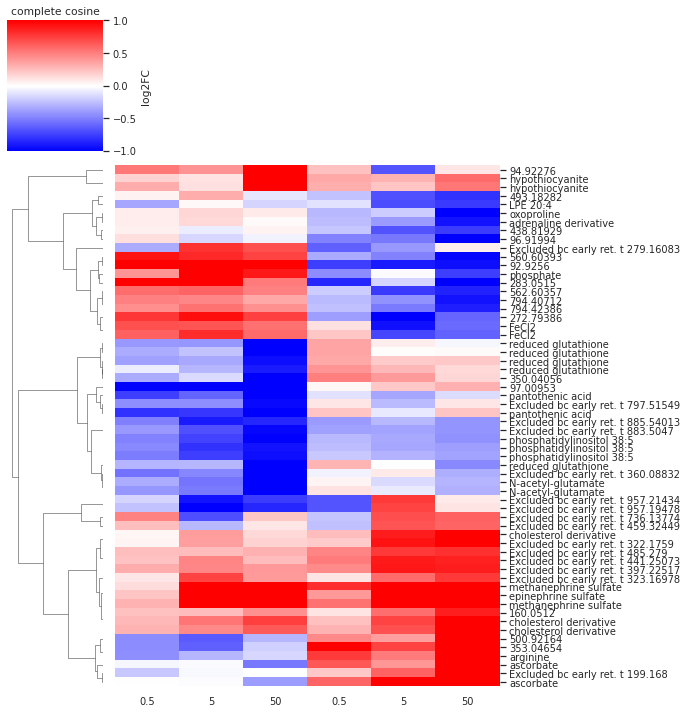

In [ ]:
# generate the figure with metabolite names
linkage_method = 'complete'
distance_metric = 'cosine'

seaborn.set(font_scale=0.9)
seaborn.clustermap(annotated_df, cmap='bwr', col_cluster=False, vmin=-1, vmax=1, method=linkage_method, metric=distance_metric, yticklabels=1, xticklabels = ['0.5', '5', '50', '0.5', '5', '50'], cbar_kws={'label':'log2FC'})

matplotlib.pyplot.title('{} {}'.format(linkage_method, distance_metric))
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

In [ ]:
annotated_df.head()

,0,1,2,3,4,5
500.92164,-0.450986,-0.642441,-0.281300,0.466293,0.377050,1.031436
hypothiocyanite,0.177647,0.112808,1.059324,0.342234,0.303839,0.580425
794.40712,0.494817,0.469856,0.336244,-0.271384,-0.423501,-0.923510
N-acetyl-glutamate,-0.324190,-0.540060,-1.015238,0.039214,-0.143395,-0.290712
oxoproline,0.071110,0.160425,0.082154,-0.275028,-0.195693,-1.067624


In [ ]:
for element in annotated_df.index:
  print(element)

500.92164
hypothiocyanite
794.40712
N-acetyl-glutamate
oxoproline
phosphatidylinositol 38:5
FeCl2
epinephrine sulfate
Excluded bc early ret. t 883.5047
794.42386
160.0512
N-acetyl-glutamate
cholesterol derivative
reduced glutathione
Excluded bc early ret. t 322.1759
Excluded bc early ret. t 441.25073
493.18282
562.60357
Excluded bc early ret. t 199.168
Excluded bc early ret. t 323.16978
Excluded bc early ret. t 736.13774
438.81929
Excluded bc early ret. t 485.279
FeCl2
hypothiocyanite
phosphatidylinositol 38:5
ascorbate
pantothenic acid
Excluded bc early ret. t 360.08832
353.04654
Excluded bc early ret. t 885.54013
Excluded bc early ret. t 797.51549
reduced glutathione
Excluded bc early ret. t 397.22517
ascorbate
pantothenic acid
adrenaline derivative
Excluded bc early ret. t 279.16083
methanephrine sulfate
phosphatidylinositol 38:5
reduced glutathione
96.91994
94.92276
560.60393
350.04056
272.79386
arginine
LPE 20:4
92.9256
reduced glutathione
phosphate
Excluded bc early ret. t 957.21

In [ ]:
storing_file = '/content/drive/MyDrive/hi/research/huvec/results/untargeted/heatmap_info.csv'
annotated_df.to_csv(storing_file)